# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [3]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [4]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [5]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [6]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    df_housing_units = sfo_data["housing_units"].groupby(sfo_data.index).mean()
    
    fig_housing_units = plt.figure()
    plot_housing_units = df_housing_units.plot.bar()
    plot_housing_units.set_xlabel("Year", fontsize=12)
    plot_housing_units.set_ylabel("Housing Units", fontsize=12)
    plot_housing_units.set_title(
        "Housing Units in San Francisco from 2010 to 2016", fontsize=14, fontweight="bold"
    )

    # Optional Challenge: Use the min, max, and std to scale the y limits of the chart
    housing_units_std = df_housing_units.std()
    housing_units_min = min(df_housing_units)
    housing_units_max = max(df_housing_units)

    plot_housing_units.set_ylim(
        housing_units_min - housing_units_std, housing_units_max + housing_units_std
    )
    plt.close(fig_housing_units)
    return pn.pane.Matplotlib(fig_housing_units, tight=True)


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    df_avg_costs = (
        sfo_data[["sale_price_sqr_foot", "gross_rent"]]
        .groupby(sfo_data.index)
        .mean()
    )
    
    fig_avg_gross_rent = plt.figure()
    plot_avg_gross_rent = df_avg_costs["gross_rent"].plot()
    plot_avg_gross_rent.set_xlabel("Year", fontsize=12)
    plot_avg_gross_rent.set_ylabel("Gross Rent", fontsize=12)
    plot_avg_gross_rent.set_title(
        "Average Gross Rent in San Francisco", fontsize=14, fontweight="bold"
    )
    plt.close(fig_avg_gross_rent)
    return pn.pane.Matplotlib(fig_avg_gross_rent, tight=True)


def average_sales_price():
    """Average Sales Price Per Year."""
    
    df_avg_costs = (
        sfo_data[["sale_price_sqr_foot", "gross_rent"]]
        .groupby(sfo_data.index)
        .mean()
    )    
    
    fig_avg_sale_price = plt.figure()
    plot_avg_sale_price = df_avg_costs["sale_price_sqr_foot"].plot()
    plot_avg_sale_price.set_xlabel("Year", fontsize=12)
    plot_avg_sale_price.set_ylabel("Avg. Sale Price", fontsize=12)
    plot_avg_sale_price.set_title(
        "Average Sale Price per Square Foot", fontsize=14, fontweight="bold"
    )
    plt.close(fig_avg_sale_price)
    return pn.pane.Matplotlib(fig_avg_sale_price, tight=True)


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    df_costs = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    df_costs.reset_index(inplace=True)
    df_costs.rename(columns={"level_0": "year"}, inplace=True)
    
    sale_price_curve = df_costs.hvplot.line(
        "year",
        "sale_price_sqr_foot",
        xlabel="Year",
        ylabel="Avg. Sale Price per Square Foot",
        groupby="neighborhood",
    )
    return sale_price_curve


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    df_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    df_expensive_neighborhoods = df_expensive_neighborhoods.sort_values(
        by="sale_price_sqr_foot", ascending=False
    ).head(10)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index()

    expensive_neighborhoods = df_expensive_neighborhoods.hvplot.bar(
        "neighborhood",
        "sale_price_sqr_foot",
        title="Top 10 Expensive Neighborhoods in SFO",
        xlabel="Neighborhood",
        ylabel="Avg. Sale Price per Square Foot",
        height=400,
        rot=90,
    )
    return expensive_neighborhoods


def parallel_coordinates():
    """Parallel Coordinates Plot."""

    df_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    df_expensive_neighborhoods = df_expensive_neighborhoods.sort_values(
        by="sale_price_sqr_foot", ascending=False
    ).head(10)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index()
    
    expensive_coordinates_plot = px.parallel_coordinates(
        df_expensive_neighborhoods,
        color="sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
    )
    return expensive_coordinates_plot


def parallel_categories():
    """Parallel Categories Plot."""
    
    df_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    df_expensive_neighborhoods = df_expensive_neighborhoods.sort_values(
        by="sale_price_sqr_foot", ascending=False
    ).head(10)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index()
    
    expensive_categories_plot = px.parallel_categories(
        df_expensive_neighborhoods,
        color="sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
    )
    return expensive_categories_plot


def neighborhood_map():
    """Neighborhood Map"""
    px.set_mapbox_access_token(map_box_api)
    
    df_all_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    df_all_neighborhoods.reset_index(inplace=True)
    df_all_neighborhoods.rename(columns={"neighborhood": "Neighborhood"}, inplace=True)

    df_all_neighborhoods = pd.merge(
        df_neighborhood_locations, df_all_neighborhoods, on="Neighborhood"
    )

    map = px.scatter_mapbox(
        df_all_neighborhoods,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=15,
        zoom=11,
        hover_name="Neighborhood",
        title="Averange Sale Price Per Square Foot and Gross Rent in San Francisco",
    )
    plotly_panel = pn.pane.Plotly(map)
    plotly_panel._updates = True
    return plotly_panel



## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [7]:
# Create a Title for the Dashboard
title = pn.pane.Markdown(
    """
# Real Estate Analysis of San Francisco from 2010 to 2016
""",
    width=800,
)

welcome = pn.pane.Markdown(
    """
This dashboard presents a visual analysis of historical prices of house units,
sale price per square foot and gross rent in San Francisco, California
from 2010 to 2016.
You can navigate through the tabs above to explore
more details about the evolution of the real estate market on
The Golden City across these years.
"""
)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Welcome", pn.Column(welcome, neighborhood_map())),
    ("Yearly Market Analysis", pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())),
    (
        "Parallel Plots Analysis",
        pn.Column(parallel_coordinates(), parallel_categories(), width=960),
    ),
)

dashboard = pn.Column(pn.Row(title), tabs, width=900)

## Serve the Panel Dashboard

Column(width=900)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
        [3] Column(width=960)
            [0] Plotly(Figure)
            [1] Plotly(Figure)
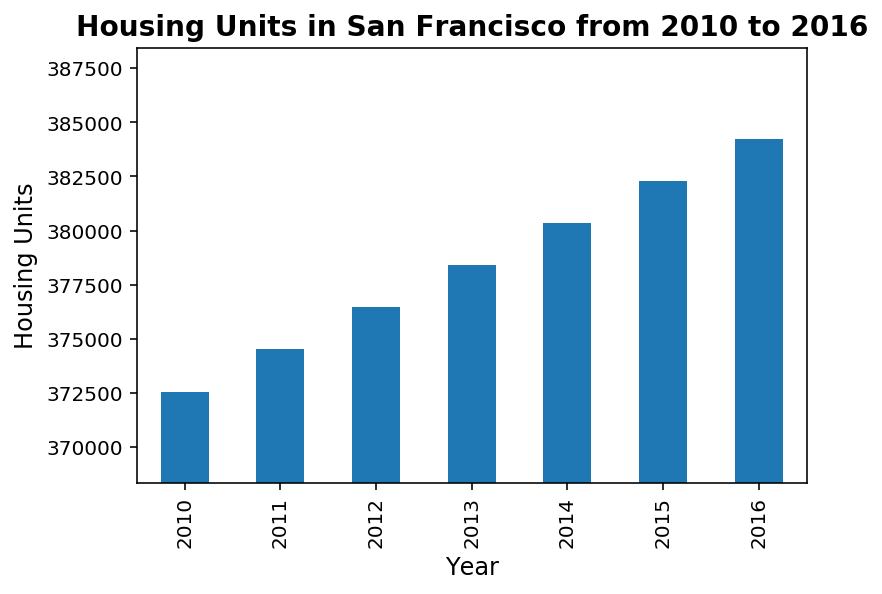
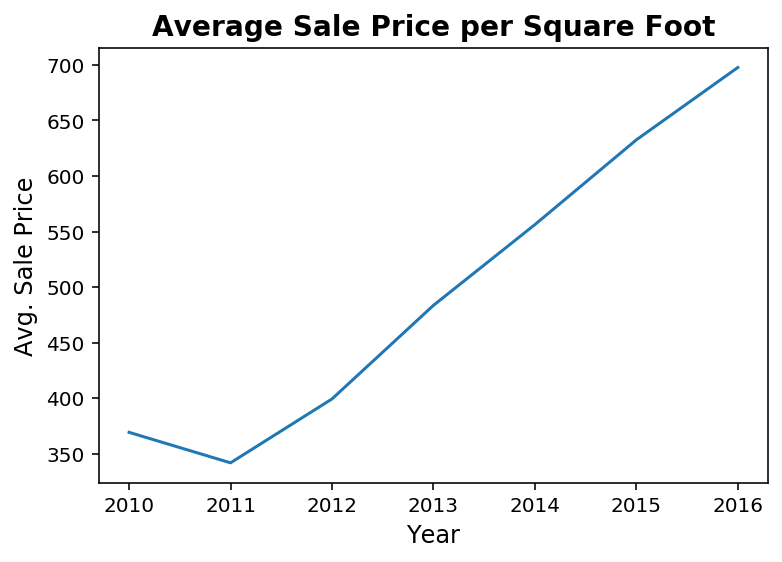
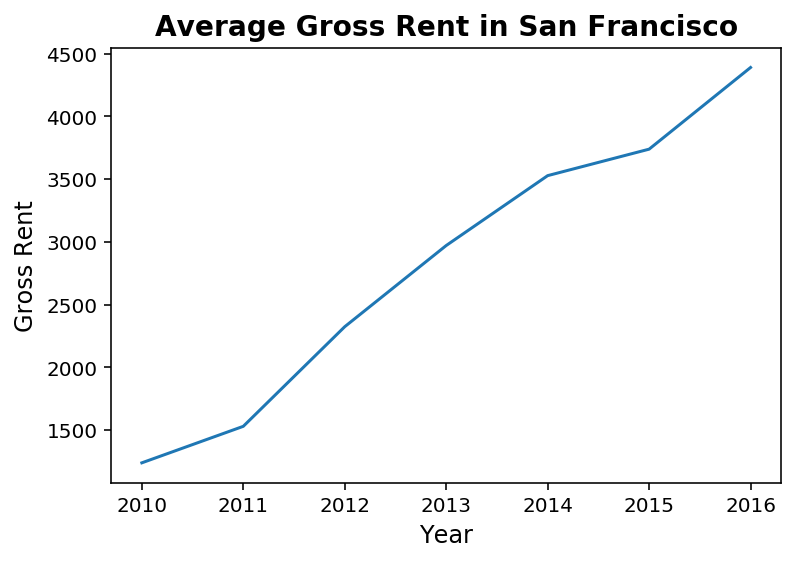

In [18]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [23]:
top_most_expensive_neighborhoods()

:Bars   [neighborhood]   (sale_price_sqr_foot)

In [9]:
# neighborhood_map().show()

In [10]:
# parallel_coordinates()

In [11]:
# parallel_categories()

In [12]:
# housing_units_per_year()

In [13]:
# average_gross_rent()

In [14]:
# average_sales_price()

In [15]:
# average_price_by_neighborhood()

In [16]:
# top_most_expensive_neighborhoods()